In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ghostbuster.raf import RAF
import torch
import time

%load_ext autoreload
%autoreload 2

## Helper Functions

In [2]:
def plot_slices(arr, start_idx=0, end_idx=None, ylabel=None):
    sz = len(arr)
    if end_idx is not None:
        indices = np.linspace(start_idx, end_idx, 5).astype(int)
    else:
        indices = np.linspace(start_idx, sz-1, 5).astype(int)
    fig, axes = plt.subplots(1, 5, constrained_layout=True, dpi=200)
    [ax.set(xticks=[], yticks=[]) for ax in axes.ravel()]
    for i, ind in enumerate(indices):
        ax = axes[i]
        ax.imshow(arr[ind])
        if arr.shape[0] == arr.shape[1]:
            ax.set_title(f'slice {ind}')
        else:
            ax.set_title(f'angle {ind}')
    if ylabel is not None:
        axes[0].set_ylabel(ylabel)
    plt.show()

In [3]:
fft2 = lambda array: torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(array)))
ifft2 = lambda array: torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(array)))
ifftn = lambda array: torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(array)))
fftn = lambda array: torch.fft.fftshift(torch.fft.fftn(torch.fft.ifftshift(array)))

------
# RAF
Here, we'll use Dataset D which contains 3500 real-valued particle intensities simulated with multislice. These particles are aberrated with defocus and spherical aberrations, and also contains ice and Poisson noise.

Due to the high memory cost of propagating 3500 complex-valued waves back and forth, as well as performing Fourier reconstruction and projection at every iteration, we suggest using CPU to perform RAF.
On our machine with 128 AMD EPYC 7736 64-Core Processors, RAF takes about ~50min to complete 50 iterations.

Users may reduce the number of particles (`Nuse`) for further speed ups, at the expense of degrading Fourier reconstruction due to lesser projections used.

In [4]:
Nuse = 3500
D_intensities = torch.load('../datasets/datasetD-5MAC_3500_icy_particles_256x256.pt')[:Nuse]
D_quaternions = torch.load('../datasets/datasetD-quaternions.pt')[:Nuse]
D_defocuses = torch.load('../datasets/datasetD-effectivedefocuses.pt')[:Nuse]
groundtruth = torch.load('../datasets/5MAC_groundtruth.pt')

In [5]:
dx = 1 # [A]
wavelength = 0.02507847 # [A], for 200keV electron wave

In [6]:
raf = RAF(D_intensities, D_quaternions, D_defocuses, wavelength,
            pixelsize=dx, device='cpu', alpha=0.1, dose=20, cs=2)

In [7]:
# Initializes RAF using the pseudoinverse algorithm.
# Ground truth is provided to monitor MSE every iteration, but note that it is not a good indicator for
# convergence since we are using the projection approximation.
raf.initialize(groundtruth=groundtruth)

Initializing volume via Pseudoinverse.
Creating vignette masks.
Vignette masks creation completed.


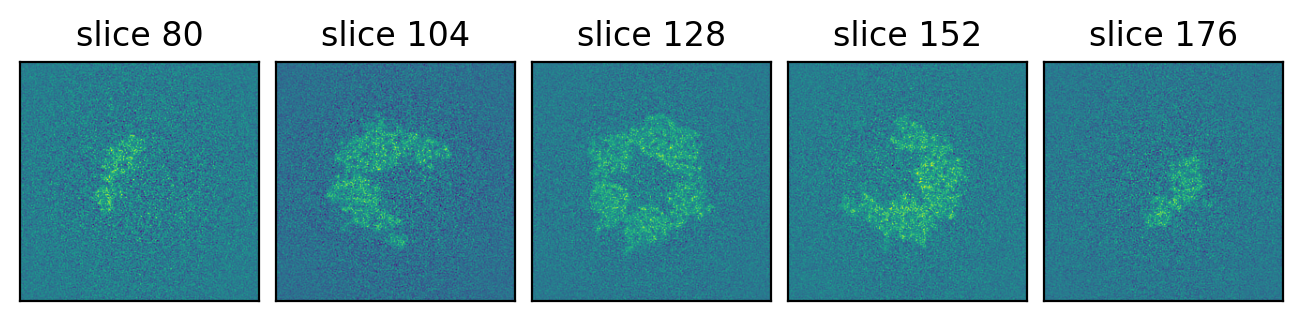

In [8]:
# take a look at initialized surrogate exitwave volume created by pseudoinverse
plot_slices(raf.init_vol.cpu().imag, 
            start_idx=80, 
            end_idx=256-80)

In [ ]:
raf.iterate(niter=50)

 12%|███████████████████▉                                                                                                                                                  | 6/50 [05:40<42:07, 57.44s/it]

In [ ]:
# take a look at phase-retrieved surrogate exitwave volume after RAF iterations
plot_slices(raf.volume.cpu().imag, 
            start_idx=80, 
            end_idx=256-80)

## Comparing to ground truth exitwaves
We also include the ground truth exitwaves from our multislice simulations. These contain the actual phases of the exitwaves. However, these ground truth exitwaves are inherently noisy due to ice. On the contrary, the exitwaves produced by either pseudoinverse or RAF inherently averages out the noise due to ice by virtue of the Fourier reconstruction/projection step.

Hence, it is instructive to also perform a similar averaging for the ground truth exitwaves to average out the effects of ice before comparing.

In [ ]:
# Dose was 20 e-/A^2 in this dataset.
# We normalize the exitwaves for comparison to RAF and pseudoinverse
D_gt_exitwaves = torch.load('datasets/datasetD-5MAC_3500_groundtruth_icy_exitwaves_256x256.pt')[:Nuse]
D_gt_exitwaves /= torch.sqrt(torch.tensor(20))

In [ ]:
# Ground truth exitwaves before averaging via Fourier reconstruction/projection
plot_slices(torch.angle(D_gt_exitwaves[:5]), ylabel='phase')
plot_slices(torch.abs(D_gt_exitwaves[:5]), ylabel='amplitude')

In [ ]:
gt_exitwaves_avg = raf.project(raf.reconstruct(D_gt_exitwaves))

In [ ]:
phase_retrieved_exitwaves = raf.project(RAF_D.volume)

In [ ]:
pseudoinverse_exitwaves = raf.project(RAF_D.init_vol)

In [ ]:
fontsize = 10
fig, axes = plt.subplots(3,6,dpi=150, figsize=(8,4), constrained_layout='tight')
for i, (im1, im2, im3) in enumerate(zip(pseudoinverse_exitwaves[:3], phase_retrieved_exitwaves[:3], gt_exitwaves_avg[:3])):
    ax = axes[0,i]
    im = ax.imshow(torch.angle(im1))
    ax.set(xticks=[], yticks=[])

    ax = axes[1,i]
    im = ax.imshow(torch.angle(im2))
    ax.set(xticks=[], yticks=[])

    ax = axes[2,i]
    im = ax.imshow(torch.angle(im3))
    ax.set(xticks=[], yticks=[])
    
    ax = axes[0,i+3]
    im = ax.imshow(torch.abs(im1))
    ax.set(xticks=[], yticks=[])

    ax = axes[1,i+3]
    im = ax.imshow(torch.abs(im2))
    ax.set(xticks=[], yticks=[])

    ax = axes[2,i+3]
    im = ax.imshow(torch.abs(im3))
    ax.set(xticks=[], yticks=[])

#ylabels
axes[0,0].set_ylabel('Pseudoinverse\ninitialization', fontsize=fontsize)
axes[1,0].set_ylabel('Phase-retrieved', fontsize=fontsize)
axes[2,0].set_ylabel('PA-averaged\nground truth', fontsize=fontsize)

#titles
axes[0,0].set_title('Angle 1, phase', fontsize=fontsize)
axes[0,1].set_title('Angle 2, phase', fontsize=fontsize)
axes[0,2].set_title('Angle 3, phase', fontsize=fontsize)
axes[0,3].set_title('Angle 1, amp', fontsize=fontsize)
axes[0,4].set_title('Angle 2, amp', fontsize=fontsize)
axes[0,5].set_title('Angle 3, amp', fontsize=fontsize)
plt.suptitle('Exitwaves comparison')
plt.show()